In [4]:
import os, sys
from argparse import Namespace
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

plt.style.use('tableau-colorblind10')

In [5]:
print('Python version:', sys.version)
print('Package versions:')
print('Pytorch:', torch.__version__)
print('Pytorch-Lightning:', pl.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
print('Weights&Biases:', wandb.__version__)

Python version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
Package versions:
Pytorch: 2.0.1+cpu
Pytorch-Lightning: 2.0.2
Matplotlib: 3.9.0
scikit-learn: 1.4.2
Weights&Biases: 0.18.5


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("boltzmannbrain/nab")

print("Path to dataset files:", path)

100%|██████████| 1.64M/1.64M [00:00<00:00, 2.27MB/s]

Extracting files...


Path to dataset files: C:\Users\jedre\.cache\kagglehub\datasets\boltzmannbrain\nab\versions\1


In [10]:
import re

In [19]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if len(re.findall('machine_temperature_system_failure', filename)) > 0:
            file_path = os.path.join(dirname, filename)

In [20]:
file_path

'C:\\Users\\jedre\\.cache\\kagglehub\\datasets\\boltzmannbrain\\nab\\versions\\1\\realKnownCause\\realKnownCause\\machine_temperature_system_failure.csv'

In [21]:
raw_dt = pd.read_csv(file_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


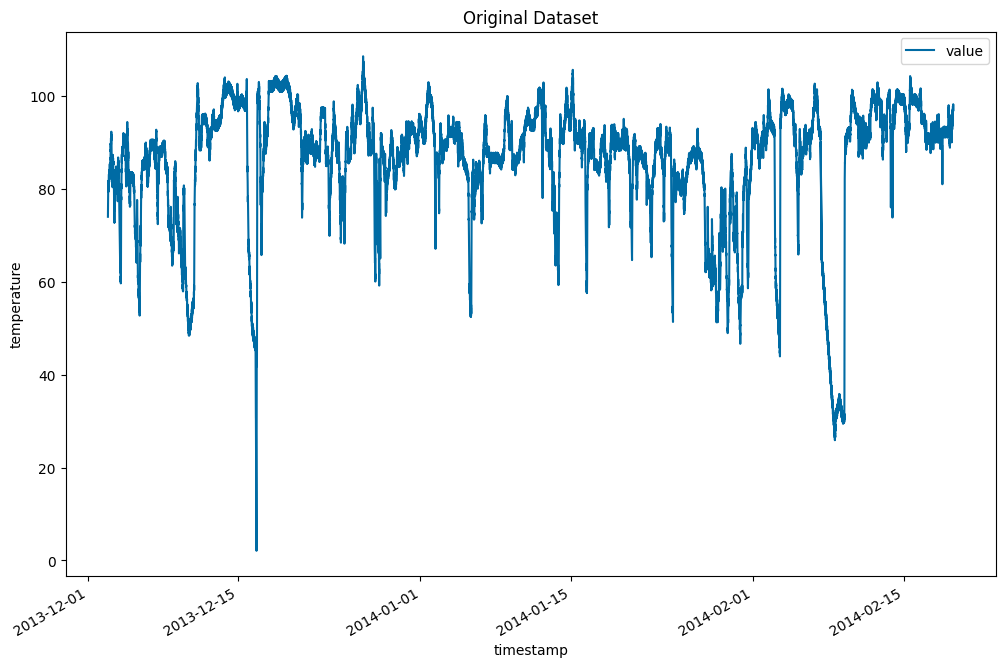

In [22]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset");

In [23]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

In [24]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [25]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [26]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [41]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

KeyError: 'timestamp'

In [40]:
data['gap_holiday'] = [i.days for i in data['gap_holiday']]

In [30]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,hol_0,hol_1,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860189
1,74.935882,1,2,21.333333,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860192
2,76.124162,1,2,21.416667,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860195
3,78.140707,1,2,21.500000,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860198
4,79.329836,1,2,21.583333,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860201
...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,"56 days, 0:00:00","49 days, 0:00:00",49,13928223
22691,97.804168,18,1,15.166667,2,0,"56 days, 0:00:00","49 days, 0:00:00",49,13928226
22692,97.135468,18,1,15.250000,2,0,"56 days, 0:00:00","49 days, 0:00:00",49,13928229
22693,98.056852,18,1,15.333333,2,0,"56 days, 0:00:00","49 days, 0:00:00",49,13928232


In [43]:
test_ratio = 0.3

In [44]:
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [45]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [47]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [48]:
tr_data.head()

,value,day,month,hour_min,day_of_week,holiday,hol_0,hol_1,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860189
1,74.935882,1,2,21.333333,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860192
2,76.124162,1,2,21.416667,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860195
3,78.140707,1,2,21.500000,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860198
4,79.329836,1,2,21.583333,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-23,13860201


In [49]:
tr_data_scaled.head()

,value,day,month,hour_min,day_of_week,holiday,hol_0,hol_1,gap_holiday,t
0,-1.224398,1,2,1.336685,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-1.866199,-1.732808
1,-1.134136,1,2,1.348691,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-1.866199,-1.732590
2,-1.023399,1,2,1.360698,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-1.866199,-1.732372
3,-0.835474,1,2,1.372704,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-1.866199,-1.732153
4,-0.724658,1,2,1.384711,0,0,"-23 days, 0:00:00","-30 days, 0:00:00",-1.866199,-1.731935


In [50]:
tr_data_scaled.to_csv(os.path.join(os.getcwd(), 'train.csv'), index=False)
tst_data_scaled.to_csv(os.path.join(os.getcwd(), 'test.csv'), index=False)

In [53]:
class TSDataset(Dataset):
    def __init__(self, split, cont_vars=None, cat_vars=None, lbl_as_feat=True):
        """
        split: 'train' if we want to get data from the training examples, 'test' for
        test examples, or 'both' to merge the training and test sets and return samples
        from either.
        cont_vars: List of continuous variables to return as features. If None, returns
        all continuous variables available.
        cat_vars: Same as above, but for categorical variables.
        lbl_as_feat: Set to True when training a VAE -- the labels (temperature values)
        will be included as another dimension of the data. Set to False when training
        a model to predict temperatures.
        """
        super().__init__()
        assert split in ['train', 'test', 'both']
        self.lbl_as_feat = lbl_as_feat
        if split == 'train':
            self.df = pd.read_csv(os.path.join(os.getcwd(), 'train.csv'))
        elif split == 'test':
            self.df = pd.read_csv(os.path.join(os.getcwd(), 'test.csv'))
        else:
            df1 = pd.read_csv(os.path.join(os.getcwd(), 'train.csv'))
            df2 = pd.read_csv(os.path.join(os.getcwd(), 'test.csv'))
            self.df = pd.concat((df1, df2), ignore_index=True)
        
        # Select continuous variables to use
        if cont_vars:
            self.cont_vars = cont_vars
            # If we want to use 'value' as a feature, ensure it is returned
            if self.lbl_as_feat:
                try:
                    assert 'value' in self.cont_vars
                except AssertionError:
                    self.cont_vars.insert(0, 'value')
            # If not, ensure it not returned as a feature
            else:
                try:
                    assert 'value' not in self.cont_vars
                except AssertionError:
                    self.cont_vars.remove('value')
                    
        else:  # if no list provided, use all available
            self.cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
        
        # Select categorical variables to use
        if cat_vars:
            self.cat_vars = cat_vars
        else:  # if no list provided, use all available
            self.cat_vars = ['day', 'month', 'day_of_week', 'holiday']
        
        # Finally, make two Numpy arrays for continuous and categorical
        # variables, respectively:
        if self.lbl_as_feat:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
        else:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
            self.lbl = self.df['value'].copy().to_numpy(dtype=np.float32)
        self.cat = self.df[self.cat_vars].copy().to_numpy(dtype=np.int64)
            
    def __getitem__(self, idx):
        if self.lbl_as_feat:  # for VAE training
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx])
        else:  # for supervised prediction
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx]), torch.tensor(self.lbl[idx])
    
    def __len__(self):
        return self.df.shape[0]

In [54]:
ds = TSDataset(split='both', cont_vars=['value', 't'], cat_vars=['day_of_week', 'holiday'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

22695
(tensor([-1.2244, -1.7328]), tensor([0, 0]))
(tensor([-1.1341, -1.7326]), tensor([0, 0]))
(tensor([-1.0234, -1.7324]), tensor([0, 0]))
(tensor([-0.8355, -1.7322]), tensor([0, 0]))
(tensor([-0.7247, -1.7319]), tensor([0, 0]))
(tensor([-0.7824, -1.7317]), tensor([0, 0]))
(tensor([-0.6371, -1.7315]), tensor([0, 0]))
(tensor([-0.6368, -1.7313]), tensor([0, 0]))
(tensor([-0.6293, -1.7311]), tensor([0, 0]))
(tensor([-0.7101, -1.7308]), tensor([0, 0]))


In [55]:
class Layer(nn.Module):
    '''
    A single fully connected layer with optional batch normalisation and activation.
    '''
    def __init__(self, in_dim, out_dim, bn = True):
        super().__init__()
        layers = [nn.Linear(in_dim, out_dim)]
        if bn: layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

    
class Encoder(nn.Module):
    '''
    The encoder part of our VAE. Takes a data sample and returns the mean and the log-variance of the 
    latent vector's distribution.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        self.embeds = nn.ModuleList([
            nn.Embedding(n_cats, emb_size) for (n_cats, emb_size) in self.hparams.embedding_sizes
        ])
        # The input to the first layer is the concatenation of all embedding vectors and continuous
        # values
        in_dim = sum(emb.embedding_dim for emb in self.embeds) + len(self.hparams.cont_vars)
        layer_dims = [in_dim] + [int(s) for s in self.hparams.layer_sizes.split(',')]
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(layer_dims[i], layer_dims[i + 1], bn) for i in range(len(layer_dims) - 1)],
        )
        self.mu = nn.Linear(layer_dims[-1], self.hparams.latent_dim)
        self.logvar = nn.Linear(layer_dims[-1], self.hparams.latent_dim)
    
    def forward(self, x_cont, x_cat):
        x_embed = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]        
        x_embed = torch.cat(x_embed, dim=1)
        x = torch.cat((x_embed, x_cont), dim=1)
        h = self.layers(x)
        mu_ = self.mu(h)
        logvar_ = self.logvar(h)
        return mu_, logvar_, x  # we return the concatenated input vector for use in loss fn
    

class Decoder(nn.Module):
    '''
    The decoder part of our VAE. Takes a latent vector (sampled from the distribution learned by the 
    encoder) and converts it back to a reconstructed data sample.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        hidden_dims = [self.hparams.latent_dim] + [int(s) for s in reversed(self.hparams.layer_sizes.split(','))]
        out_dim = sum(emb_size for _, emb_size in self.hparams.embedding_sizes) + len(self.hparams.cont_vars)
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(hidden_dims[i], hidden_dims[i + 1], bn) for i in range(len(hidden_dims) - 1)],
        )
        self.reconstructed = nn.Linear(hidden_dims[-1], out_dim)
        
    def forward(self, z):
        h = self.layers(z)
        recon = self.reconstructed(h)
        return recon

In [56]:
class VAE(pl.LightningModule):
    def __init__(self, **hparams):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(**hparams)
        self.decoder = Decoder(**hparams)
        
    def reparameterize(self, mu, logvar):
        '''
        The reparameterisation trick allows us to backpropagate through the encoder.
        '''
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * self.hparams.stdev
            return eps * std + mu
        else:
            return mu
        
    def forward(self, batch):
        x_cont, x_cat = batch
        assert x_cat.dtype == torch.int64
        mu, logvar, x = self.encoder(x_cont, x_cat)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, x
        
    def loss_function(self, obs, recon, mu, logvar):
        recon_loss = F.smooth_l1_loss(recon, obs, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld
                               
    def training_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        # The loss function compares the concatenated input vector including
        # embeddings to the reconstructed vector
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld

        self.log('total_loss', loss.mean(dim=0), on_step=True, prog_bar=True, 
                 logger=True)
        self.log('recon_loss', recon_loss.mean(dim=0), on_step=True, prog_bar=True, 
                 logger=True)
        self.log('kld', kld.mean(dim=0), on_step=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld
        self.log('test_loss', loss)
        return loss
        
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay, 
                                eps=1e-4)
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=25, T_mult=1, eta_min=1e-9, last_epoch=-1)
        return [opt], [sch]
    
    def train_dataloader(self):
        dataset = TSDataset('train', cont_vars=self.hparams.cont_vars, 
            cat_vars = self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2, 
            pin_memory=True, persistent_workers=True, shuffle=True
        )
    
    def test_dataloader(self):
        dataset = TSDataset('test', cont_vars=self.hparams.cont_vars,
            cat_vars=self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2, 
            pin_memory=True, persistent_workers=True
        )

In [57]:
cont_features = ['value', 'hour_min', 'gap_holiday', 't'] 
cat_features = ['day_of_week', 'holiday']  # Remember that we removed `day` and `month`

embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]

hparams = OrderedDict(
    run='embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1',
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes = [(embed_cats[i], 16) for i in range(len(embed_cats))],
    latent_dim = 16,
    layer_sizes = '64,128,256,128,64',
    batch_norm = True,
    stdev = 0.1,
    kld_beta = 0.05,
    lr = 0.001,
    weight_decay = 1e-5,
    batch_size = 128,
    epochs = 60,
)

In [58]:
hparams

OrderedDict([('run',
              'embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1'),
             ('cont_vars', ['value', 'hour_min', 'gap_holiday', 't']),
             ('cat_vars', ['day_of_week', 'holiday']),
             ('embedding_sizes', [(7, 16), (2, 16)]),
             ('latent_dim', 16),
             ('layer_sizes', '64,128,256,128,64'),
             ('batch_norm', True),
             ('stdev', 0.1),
             ('kld_beta', 0.05),
             ('lr', 0.001),
             ('weight_decay', 1e-05),
             ('batch_size', 128),
             ('epochs', 60)])

In [67]:
model = VAE(**hparams)
# logger = WandbLogger(name=hparams['run'], project='VAE_Anomaly', version=hparams['run'],
#      save_dir='kaggle/working/checkpoints'
# )
ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath='.', filename='vae_weights')
# Replace argument logger by None if you don't have a WandB account (and don't want to create one)
trainer = pl.Trainer(
    # accelerator='gpu', 
    devices=1, 
    # strategy='dp', 
    # logger=logger,  
    max_epochs=hparams['epochs'], 
    # auto_lr_find=False, 
    benchmark=True,
    callbacks=[ckpt_callback], 
    gradient_clip_val=10., 
    enable_model_summary=True
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

Missing logger folder: c:\Users\jedre\OneDrive\Pulpit\State_Street\Programs\Python\ML_Research_Project_2024\VAE\.vscode\lightning_logs
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory . exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 88.4 K
1 | decoder | Decoder | 87.2 K
------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.702     Total estimated model params size (MB)


In [ ]:
trainer.test(model)

In [ ]:
dataset = TSDataset('test', cont_vars=hparams['cont_vars'],
                    cat_vars=['day_of_week', 'holiday'],
                    lbl_as_feat=True) 

In [ ]:
trained_model = VAE.load_from_checkpoint('./vae_weights-v1.ckpt')
trained_model.freeze()

losses = []
# run predictions for the training set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont.unsqueeze_(0)
    x_cat.unsqueeze_(0)
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss + trained_model.hparams.kld_beta * kld)
    
data_with_losses = dataset.df
data_with_losses['loss'] = np.asarray(losses)
data_with_losses.sort_values('t', inplace=True)
data_with_losses.head()

In [ ]:
mean, sigma = data_with_losses['loss'].mean(), data_with_losses['loss'].std()
mean, sigma

In [ ]:
quant = 0.999
thresh = data_with_losses['loss'].quantile(quant)  # threshold for anomaly (quantile).
thresh

In [ ]:
data_with_losses['anomaly'] = data_with_losses['loss'] > thresh
print(data_with_losses.head())

In [ ]:
plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();

In [ ]:
data_with_losses_unscaled = data_with_losses.copy()
data_with_losses_unscaled[cont_vars] = scaler.inverse_transform(data_with_losses[cont_vars])
for enc, var in zip(label_encoders, cat_vars):
    data_with_losses_unscaled[var] = enc.inverse_transform(data_with_losses[var])
data_with_losses_unscaled = pd.DataFrame(data_with_losses_unscaled, columns=data_with_losses.columns)
data_with_losses_unscaled['timestamp'] = pd.to_datetime(data_with_losses_unscaled['t'] * 1e11, unit='ns')

print(data_with_losses_unscaled.head())

In [ ]:
anomalies_value = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ['loss','value']]
normals_value = data_with_losses_unscaled.loc[~data_with_losses_unscaled['anomaly'], ['loss','value']]
plt.figure(figsize=(8,8))
plt.hist([normals_value['value'], anomalies_value['value']], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Temperature Distribution, Test Set")
plt.xlabel("Temperature (binned)")
plt.ylabel("Count")
plt.legend()
;

In [ ]:
anomalies_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_with_losses_unscaled['timestamp'], data_with_losses_unscaled['value'], alpha=.5)
ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period");